In [1]:
import aux_fun as functions
import SXS_module as sxs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize,curve_fit
import romspline
import h5py
import math
from dynesty.utils import resample_equal
import corner
import json
import random

In [2]:
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
#qnm.download_data()

In [3]:
import glob
json_files=glob.glob('/work/francisco.jimenez/RIT/Metadata/*Metadata.json',recursive = True)

In [4]:
import importlib
importlib.reload(sxs)
conditions=np.asarray([['BHBH',None],['Non-Precessing',None],['Eccentricity',['>=0.01','<=1']]])
ritcat=sxs.SXS_catalogue("/work/francisco.jimenez/RIT/Data",conditions,catalogue="RIT")

systems=np.array([ritcat.metadata(j,parameters_list=['catalog-tag','system-type','eccentricity','relaxed-mass-ratio-1-over-2',
                                                     'final-mass','final-chi','initial-bh-chi1z','initial-bh-chi2z']) for j in json_files])

#doesn't work

/work/kailai.wang/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
len(systems)

1881

In [6]:
boolean= np.array(['e' in elist for elist in systems[:,0]])
ecc_prec_cases=systems[boolean]
boolean = np.array(['Precessing' not in elist for elist in ecc_prec_cases])
ecc_cases=ecc_prec_cases[boolean]
ecc_cases[:,2]=np.array([float(i[2]) for i in ecc_cases])
ecc_cases[:,3]=np.array([1/float(i[3]) for i in ecc_cases])
ecc_cases[:,4]=np.array([float(i[4]) for i in ecc_cases])
ecc_cases[:,5]=np.array([float(i[5]) for i in ecc_cases])
ecc_tags=ecc_cases[:,0]
h5_files=[glob.glob('/work/francisco.jimenez/RIT/Data/*'+j.replace(':','-')+'*',recursive = True)[0] for j in ecc_tags]

In [7]:
modes=[[2,2]]
#ecc_tags,len(ecc_tags)
#h5_files

In [8]:
wave={}
ecc_cases_noq1=[]
#for i in range(len(h5_files)):
for i in range(2):
    try:
        tag=ecc_tags[i]
        wave[tag]=sxs.Generate_Georgia_Waveform(h5_files[i],modes,
                                        zero_align=False,
                                        sampling_rate=0.1,modes_combined=False,inclination=0,
                                        coa_phase=0,RD=False,toffset=0)
        ecc_cases_noq1.append(ecc_cases[i])

    except:
        pass

In [47]:
ecc_tags[0]

'RIT:eBBH:1848'

In [58]:
wave[ecc_tags[0]][0][:,1]

array([-1.65984192e-24-8.44162630e-47j,  9.98173710e-09-3.35646691e-16j,
        1.73717359e-08-9.51073319e-16j, ...,
       -8.91027155e-09+5.76862169e-17j, -4.48748311e-09+1.46329083e-17j,
        0.00000000e+00+0.00000000e+00j])

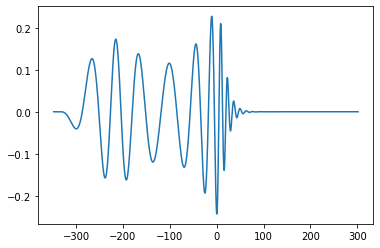

In [59]:
plt.plot(wave[ecc_tags[1]][0][:,0],wave[ecc_tags[1]][0][:,1])

In [11]:
ecc_cases_noq1_v1=np.array(ecc_cases_noq1)

In [60]:
vars_ml22=[]
vars_ml33=[]

initial22=[random.random(),random.random()*2*np.pi]
initial33=[random.random(),random.random()*2*np.pi]
massratio=[]
ecc=[]
chi_eff=[]
chi_a=[]

rdowlike=log_likelihood
nll = lambda *args: -rdowlike(*args)

bnds = ((None, None), (None, None))
for i in range(len(ecc_cases_noq1_v1)):
    #try:
        af=float(ecc_cases_noq1_v1[i,5])
        mf=float(ecc_cases_noq1_v1[i,4])

        if af<=0:
            afn=abs(af)
            qnmspec=QNM_spectrum(2,-2,0,mf,afn)
        else:
            afn=af
            qnmspec=QNM_spectrum(2,2,0,mf,afn)
        time=wave[ecc_cases_noq1_v1[i,0]][0][:,0].real
        data=wave[ecc_cases_noq1_v1[i,0]][0][:,1]
        
        soln = minimize(nll, initial22,method='SLSQP', bounds=bnds)
        massratio.append(float(ecc_cases_noq1_v1[i,3]))
        mass1=massratio[i]/(massratio[i]+1)
        mass2=1/(massratio[i]+1)

        spin1z=float(ecc_cases_noq1_v1[i,-2])
        spin2z=float(ecc_cases_noq1_v1[i,-1])

        chi_eff.append(spin1z*mass1+spin2z*mass2)
        chi_a.append(spin1z*mass1-spin2z*mass2)
        ecc.append(float(ecc_cases_noq1_v1[i,2]))
        vars_ml22.append(list(soln.x))


        if af<=0:
            afn=abs(af)
            qnmspec=QNM_spectrum(3,-3,0,mf,afn)
        else:
            afn=af
            qnmspec=QNM_spectrum(3,3,0,mf,afn)
        time=wave[ecc_cases_noq1_v1[i,0]][1][:,0].real
        data=wave[ecc_cases_noq1_v1[i,0]][1][:,1]
        soln = minimize(nll, initial33,method='SLSQP', bounds=bnds)
        vars_ml33.append(list(soln.x))
    #except:
    #    print(i)
    #    pass
    
vars_ml22=np.array(vars_ml22)
vars_ml33=np.array(vars_ml33)

for i in range(len(vars_ml22)):
    if (vars_ml22[i][0]<0):
        vars_ml22[i][1]=vars_ml22[i][1]+np.pi
        vars_ml22[i][0]=abs(vars_ml22[i][0])
    if (vars_ml33[i][0]<0):
        vars_ml33[i][1]=vars_ml33[i][1]+np.pi
        vars_ml33[i][0]=abs(vars_ml33[i][0])

NameError: name 'log_likelihood' is not defined

In [ ]:
plt.plot(massratio,(vars_ml33[:,0]/vars_ml22[:,0]),'o',label='10M')
plt.ylim(0,0.5)
plt.xlim(1,15)

In [ ]:
q_sel=3
massratio=np.array(massratio)
ecc=np.array(ecc)
boolean=  np.logical_and(massratio < q_sel+0.1, massratio > q_sel-0.1)
massratio_sel=massratio[boolean]
vars_ml33_sel=vars_ml33[boolean]
vars_ml22_sel=vars_ml22[boolean]
ecc_sel=ecc[boolean]
plt.plot(ecc_sel,(vars_ml33_sel[:,0]/vars_ml22_sel[:,0]),'o',label='q='+str(q_sel))
plt.ylim(0,0.5)
plt.legend()
plt.xlabel('ecc')
plt.ylabel(r'$A^R_{330}$')


In [ ]:
plt.plot(massratio,(3/2*vars_ml22[:,1]-vars_ml33[:,1]+np.pi/2)%(2*np.pi),'o',label='10M')
plt.axhline(np.pi)

In [ ]:
q_sel=3
massratio=np.array(massratio)
ecc=np.array(ecc)
boolean=  np.logical_and(massratio < q_sel+0.1, massratio > q_sel-0.1)
massratio_sel=massratio[boolean]
vars_ml33_sel=vars_ml33[boolean]
vars_ml22_sel=vars_ml22[boolean]
ecc_sel=ecc[boolean]
plt.plot(ecc_sel,(3/2*vars_ml22_sel[:,1]-vars_ml33_sel[:,1]+np.pi/2)%(np.pi),'o',label='q='+str(q_sel))
plt.legend()
plt.xlabel('ecc')
plt.ylabel(r'$\delta\phi_{330}$')


In [ ]:
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_RD_amp_phase_22_rob.txt', vars_ml22)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_RD_amp_phase_33_rob.txt', vars_ml33)

np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_massratio_rob.txt', massratio)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_ecc_rob.txt', ecc)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_chi_eff_rob.txt', chi_eff)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_chi_a_rob.txt', chi_a)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_ecc_tags_rob.txt', tags_rit,fmt='%s')

In [ ]:
import importlib
importlib.reload(sxs)
conditions=np.asarray([['BHBH',None],['Precessing']])
ritcat=sxs.SXS_catalogue("/work/francisco.jimenez/RIT/Data",conditions,catalogue="RIT")
systems=np.array([ritcat.metadata(j,parameters_list=['catalog-tag','system-type','eccentricity','relaxed-mass-ratio-1-over-2','final-mass',
                                                     'final-chi','initial-bh-chi1x','initial-bh-chi1y','initial-bh-chi2x','initial-bh-chi2y',
                                                    'initial-bh-chi1z','initial-bh-chi2z']) for j in json_files])

In [8]:
ritcat.nr_metadata_keys()

['catalog-tag',
 'system-type',
 'initial-mass1',
 'initial-mass2',
 'relaxed-mass-ratio-1-over-2',
 'initial-bh-chi1z',
 'initial-bh-chi2z',
 'initial-bh-chi1x',
 'initial-bh-chi1y',
 'initial-bh-chi2x',
 'initial-bh-chi2y',
 'eccentricity',
 'final-mass',
 'final-chi']

In [9]:
boolean= systems[:,1]=='Precessing'
ecc_prec_cases=systems[boolean]
boolean= np.array(['e' not in elist for elist in ecc_prec_cases[:,0]])
ecc_prec_cases=ecc_prec_cases[boolean]
h5_files=[glob.glob('/work/francisco.jimenez/RIT/Data/*'+j.replace(':','-')+'*',recursive = True)[0] for j in ecc_prec_cases[:,0]]

In [10]:
modes=[[2,2],[3,3]]

In [11]:
wave={}
ecc_cases_noq1=[]
for i in range(len(h5_files)):
    try:
        tag=ecc_prec_cases[i,0]
        wave[tag]=sxs.Generate_Georgia_Waveform(h5_files[i],modes,
                                        zero_align=False,
                                        sampling_rate=0.1,modes_combined=False,inclination=0,
                                        coa_phase=0,RD=True,toffset=10)
        ecc_cases_noq1.append(ecc_prec_cases[i])

    except:
        print(i)
        pass

131
186
202
233
271
279
362
387
413


In [14]:
ecc_cases_noq1_v1=np.array(ecc_cases_noq1)
len(ecc_cases_noq1_v1)

437

In [19]:
vars_ml22=[]
vars_ml33=[]

initial22=[random.random(),random.random()*2*np.pi]
initial33=[random.random(),random.random()*2*np.pi]
massratio=[]

chi_p=[]
chi_eff=[]
tags_rit=[]
chi_a=[]

rdowlike=log_likelihood
nll = lambda *args: -rdowlike(*args)

bnds = ((None, None), (None, None))
for i in range(len(ecc_cases_noq1_v1)):
    #try:
        af=float(ecc_cases_noq1_v1[i,4])
        mf=float(ecc_cases_noq1_v1[i,5])

        if af<=0:
            afn=abs(af)
            qnmspec=QNM_spectrum(2,-2,0,mf,afn)
        else:
            afn=af
            qnmspec=QNM_spectrum(2,2,0,mf,afn)
        time=wave[ecc_cases_noq1_v1[i,0]][0][:,0].real
        data=wave[ecc_cases_noq1_v1[i,0]][0][:,1]
        soln = minimize(nll, initial22,method='SLSQP', bounds=bnds)
        massratio.append(1/float(ecc_cases_noq1_v1[i,3]))
        A1=(2+3*massratio[i]/(2.))
        A2=(2+3/(2.*massratio[i])) 
        mass1=massratio[i]/(massratio[i]+1)
        mass2=1/(massratio[i]+1)
        
        chi_z1=float(ecc_cases_noq1_v1[i,10])
        chi_z2=float(ecc_cases_noq1_v1[i,11])
        chi_x1=float(ecc_cases_noq1_v1[i,6])
        chi_y1=float(ecc_cases_noq1_v1[i,7])
        chi_x2=float(ecc_cases_noq1_v1[i,8])
        chi_y2=float(ecc_cases_noq1_v1[i,9])
        chi_p1 = np.sqrt(chi_x1**2+chi_y1**2)*mass1**2
        chi_p2 = np.sqrt(chi_x2**2+chi_y2**2)*mass2**2
        chi_p.append(max(A1*chi_p1,A2*chi_p2)/(A1*mass1**2))      
        chi_eff.append(mass1*chi_z1+chi_z2*mass2)
        chi_a.append(mass1*chi_z1-chi_z2*mass2)
        tags_rit.append(ecc_cases_noq1_v1[i,0])
        
        vars_ml22.append(list(soln.x))


        if af<=0:
            afn=abs(af)
            qnmspec=QNM_spectrum(3,-3,0,mf,afn)
        else:
            afn=af
            qnmspec=QNM_spectrum(3,3,0,mf,afn)
        time=wave[ecc_cases_noq1_v1[i,0]][1][:,0].real
        data=wave[ecc_cases_noq1_v1[i,0]][1][:,1]
        soln = minimize(nll, initial33,method='SLSQP', bounds=bnds)
        vars_ml33.append(list(soln.x))
    #except:
    #    pass
    
vars_ml22=np.array(vars_ml22)
vars_ml33=np.array(vars_ml33)

for i in range(len(vars_ml22)):
    if (vars_ml22[i][0]<0):
        vars_ml22[i][1]=vars_ml22[i][1]+np.pi
        vars_ml22[i][0]=abs(vars_ml22[i][0])
    if (vars_ml33[i][0]<0):
        vars_ml33[i][1]=vars_ml33[i][1]+np.pi
        vars_ml33[i][0]=abs(vars_ml33[i][0])

(1.0, 15.0)

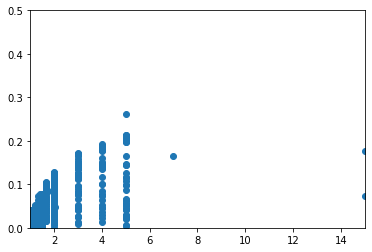

In [20]:
plt.plot(massratio,(vars_ml33[:,0]/vars_ml22[:,0]),'o',label='10M')
plt.ylim(0,0.5)
plt.xlim(1,15)

Text(0, 0.5, '$A^R_{330}$')

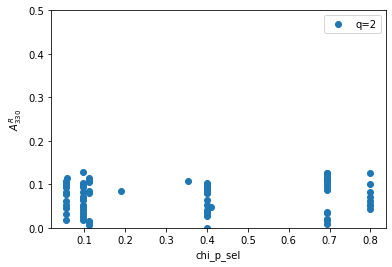

In [21]:
q_sel=2
massratio=np.array(massratio)
chi_p=np.array(chi_p)
boolean=  np.logical_and(massratio < q_sel+0.1, massratio > q_sel-0.1)
massratio_sel=massratio[boolean]
vars_ml33_sel=vars_ml33[boolean]
vars_ml22_sel=vars_ml22[boolean]
chi_p_sel=chi_p[boolean]
plt.plot(chi_p_sel,(vars_ml33_sel[:,0]/vars_ml22_sel[:,0]),'o',label='q='+str(q_sel))
plt.ylim(0,0.5)
plt.legend()
plt.xlabel('chi_p_sel')
plt.ylabel(r'$A^R_{330}$')

/work/francisco.jimenez/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 200.0)

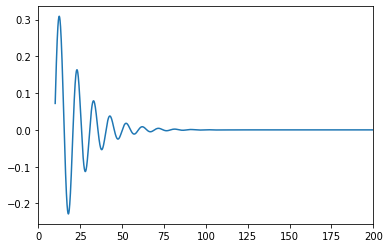

In [22]:
plt.plot(wave[tag][0][:,0],wave[tag][0][:,1])
plt.xlim(0,200)

In [23]:
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_RD_amp_phase_22_rob.txt', vars_ml22)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_RD_amp_phase_33_rob.txt', vars_ml33)

np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_massratio_rob.txt', massratio)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_chi_p_rob.txt', chi_p)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_chi_eff_rob.txt', chi_eff)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_chi_a_rob.txt', chi_a)
np.savetxt('/work/francisco.jimenez/sio/git/RDFits_amp_phase/amp_files/rit_prec_tags_rob.txt', tags_rit,fmt='%s')

In [40]:
h22,h2m2=sxs.Generate_Georgia_Waveform(h5_files[i],[[2,2],[2,-2]],
                                        zero_align=False,
                                        sampling_rate=0.1,modes_combined=False,inclination=0,
                                        coa_phase=0,RD=True,toffset=10)

/work/francisco.jimenez/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/work/francisco.jimenez/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


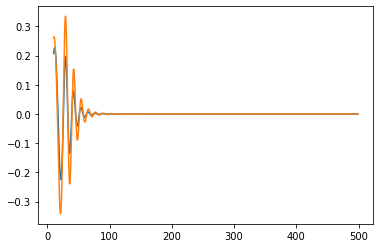

In [41]:
plt.plot(h22[:,0],h22[:,1])
plt.plot(h2m2[:,0],h2m2[:,1])